# Testing Predictions Pepper Buetepage

RuntimeError: CUDA error: out of memory

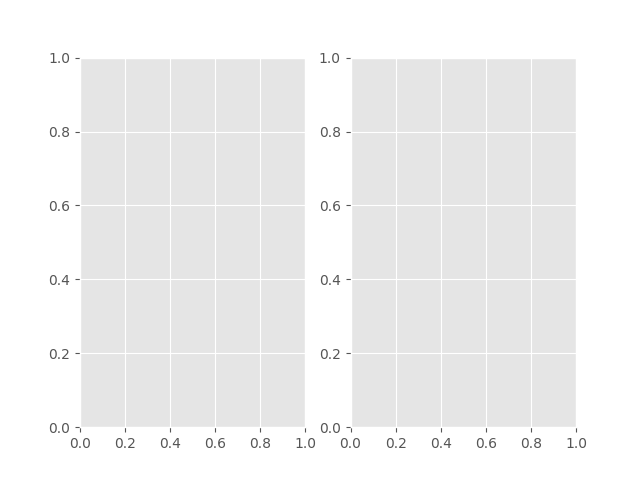

In [3]:
%matplotlib widget
import numpy as np
import scipy
import matplotlib.pyplot as plt
from test import evaluate_ckpt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

fig = plt.figure()
plt.title('MSE of predicted robot joints after observing human')
ax_box_pred = plt.subplot(1,2,1)
# ax_box_vae = plt.subplot(2,2,2)
ax_bar_pred = plt.subplot(1,2,2)
# ax_bar_vae = plt.subplot(2,2,4)
k = 0

pred_mse = []
# vae_mse = []

for model_type, use_cov in [
                        ('vae_vanilla', False),#, 'final.pth'),
                        # ('vae_vanilla_hsmm', False),#, 'final.pth'),
                        ('vae_crossrecon_samplenocovcond', False),#, 'final.pth'),
                        ('vae_crossrecon_samplecovcond', True),#, 'final.pth'),
                        ('vae_crossrecon_nocovcondsampling', False),#, 'final.pth'),
                        ('vae_crossrecon_covcondsampling', True),#, 'final.pth'),
                        # ('vae_crossrecon_nocovcond', False),#, 'final.pth'),
                        # ('vae_crossrecon_covcond', True),#, 'final.pth'),
                        # ('mild_vanilla', False),#, 'final.pth'),
                        # # ('mild_vanilla_hsmm', False),#, 'final.pth'),
                        # ('mild_crossrecon_samplenocovcond', False),#, 'final_250.pth'),
                        # ('mild_crossrecon_samplecovcond', True),#, 'final.pth'),
                        # ('mild_crossrecon_nocovcondsampling', False),#, 'final.pth'),
                        # ('mild_crossrecon_covcondsampling', True),#, 'final.pth'),
                        # # ('mild_crossrecon_nocovcond', False),#, 'final_250.pth'),
                        # # ('mild_crossrecon_covcond', True),#, 'final.pth'),
                    ]:
    pred_mse.append([])
    for ckpt_name in [
                        'final_100.pth', 
                        # 'final_100_finetuning.pth', 
                        # 'final_199.pth', 
                        # 'final_199_finetuning.pth',
                    ]:
        pred_mse_k = []

        for trial in range(4):
            ckpt_path = f'logs/2023/bp_pepper/hsmm/{model_type}/z5/trial{trial}/models/{ckpt_name}'

            pred_mse_ckpt, _ = evaluate_ckpt(ckpt_path, use_cov)
            pred_mse_k += pred_mse_ckpt
        pred_mse[-1].append(pred_mse_k)
        if ckpt_name[10:] == 'finetuning.pth':
            ckpt_name = 'tuned_'+ckpt_name[6:9]
        # elif ckpt_name == 'final_100.pth':
            # ckpt_name = 'final_100'
        else:
            ckpt_name = ckpt_name[:-4]
        model_name = f'{model_type:<40}' + str(use_cov)[0] + f' {ckpt_name}'
        if ckpt_name=='final_100':
            positions=[k]
        elif ckpt_name=='final_199':
            positions=[k+0.5]
        ax_box_pred.boxplot(pred_mse_k, positions=positions, showfliers=False, widths=[0.8])
        # print(f'{model_name}\t{np.mean(pred_mse):.4e} ± {np.std(pred_mse):.4e} \t{np.mean(vae_mse):.4e} ± {np.std(vae_mse):.4e}')
    k+=1

p_values = np.ones((len(pred_mse), len(pred_mse)))
for i in range(len(pred_mse)-1):
    for j in range(i+1,len(pred_mse)):
        p_values[i,j] = scipy.stats.ttest_ind(pred_mse[i][0], pred_mse[j][0]).pvalue
        print(i,j,p_values[i,j])

p_values = np.ones((len(pred_mse), len(pred_mse)))
for i in range(len(pred_mse)-1):
    for j in range(i+1,len(pred_mse)):
        p_values[i,j] = scipy.stats.ttest_rel(pred_mse[i][0], pred_mse[j][0]).pvalue
        print(i,j,p_values[i,j])

p_values = np.ones((len(pred_mse), len(pred_mse)))
for i in range(len(pred_mse)-1):
    for j in range(i+1,len(pred_mse)):
        p_values[i,j] = scipy.stats.mannwhitneyu(pred_mse[i][0], pred_mse[j][0]).pvalue
        print(i,j,p_values[i,j])


X = np.arange(len(pred_mse))
ax_bar_pred.bar(X, [np.mean(pred_mse[i][0]) for i in range(len(pred_mse))], color = 'b', width = 0.5)#, label='100 epochs')
# ax_bar_pred.bar(X + 0.6, [np.mean(pred_mse[i][1]) for i in range(len(pred_mse))], color = 'm', width = 0.2, label='200 Epochs')
ax_bar_pred.set_ylabel('Prediction MSE')
ax_box_pred.set_ylabel('Prediction MSE')
ax_bar_pred.set_xticks(X, ('#1', '#2.1', '#2.2', '#3.1', '#3.1'))
ax_box_pred.set_xticks(X, ('#1', '#2.1', '#2.2', '#3.1', '#3.2'))
# ax_bar_pred.legend()


**\#1 - Standard VAE Loss $\mathcal{L}_t = \mathbb{E}_{q_h}\log p(\boldsymbol{x}^h_t|\boldsymbol{z}^h_t) + \mathbb{E}_{q_r}\log p(\boldsymbol{x}^r_t|\boldsymbol{z}^r_t) + \mathcal{L}_{KL}$**

The following  use an additional conditional reconstruction term 
$\mathcal{L}_t = \mathbb{E}_{q_h}\log p(\boldsymbol{x}^h_t|\boldsymbol{z}^h_t) + \mathbb{E}_{q_r}\log p(\boldsymbol{x}^r_t|\boldsymbol{z}^r_t) + \mathcal{L}_{KL} + \mathbb{E}_{p(z_r|z_h)q_h}\log p(\boldsymbol{x}^r_t|\boldsymbol{z}^r_t)$

The explanation of how the additional loss is calculated is shown below

**\#2 MSE of conditioned reconstruction of monte carlo samples drawn from the posterior distribution**

**\#2.1 Sample conditioning without posterior covariance**
- Sampling from the posterior $\boldsymbol{z}^h_t \sim q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Conditioning these samples without post. covariance $\hat{\boldsymbol{z}}^r_t = \sum_{k=1}^K \bar h_i^t (\boldsymbol{\mu}^r_i + \boldsymbol{\Sigma}^{rh}_i(\boldsymbol{\Sigma}^{hh}_i)^{-1}(\boldsymbol{\mu}^h_i - \boldsymbol{z}^h_t))$
- Reconstructing $\hat{\boldsymbol{z}}^r_t$ and calculating the loss as an average over the samples from the posterior


**\#2.2 Sample conditioning with posterior covariance**
- Sampling from the posterior $\boldsymbol{z}^h_t \sim q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Conditioning these samples with post. covariance $\hat{\boldsymbol{z}}^r_t = \sum_{k=1}^K \bar h_i^t (\boldsymbol{\mu}^r_i + \boldsymbol{\Sigma}^{rh}_i(\boldsymbol{\Sigma}^{hh}_i+ \boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t))^{-1}(\boldsymbol{\mu}^h_i - \boldsymbol{z}^h_t))$
- Reconstructing $\hat{\boldsymbol{z}}^r_t$ and calculating the loss as an average over the samples from the posterior

**\#3 MSE of conditioned reconstruction of monte carlo samples drawn from the conditional distribution**

**\#3.1 Conditional distribution sampling without posterior covariance**
- Calculate the posterior distribution $\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t),\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t) = q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Calculate the conditional distribution using the mean without post. covariance 
$$
  \boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{\mu}}^r_i = {\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})\\
    \boldsymbol{\hat{\Sigma}}^r_i = {\color{orange}\boldsymbol{\Sigma}^{rr}_i} - \boldsymbol{K}_i{\color{orange}\boldsymbol{\Sigma}^{hr}_i} + \boldsymbol{\hat{\mu}}^r_i(\boldsymbol{\hat{\mu}}^r_i)^T\\
    \boldsymbol{\hat{\mu}}^r_t = \sum_{i=1}^N {\color{orange}\bar h_i^t} \hspace{0.2em} \boldsymbol{\hat{\mu}}^r_i\\
    \boldsymbol{\hat{\Sigma}}^r_t = \left[\sum_{i=1}^N {\color{orange}\bar h_i^t} \hspace{0.2em} \boldsymbol{\hat{\Sigma}}^r_i\right]  - \boldsymbol{\hat{\mu}}^r_t(\boldsymbol{\hat{\mu}}^r_t)^T\\
    % p(\boldsymbol{z}_t^r | {\color{magenta}q_t^h}) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t) 
$$
- Draw samples from the conditional distribution $\hat{\boldsymbol{z}}^r_t \sim \mathcal{N}(\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t)$
- Reconstructing $\hat{\boldsymbol{z}}^r_t$ and calculating the loss as an average over the samples from the conditional distribution


**\#3.1 Conditional distribution sampling without posterior covariance**
- Calculate the posterior distribution $\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t),\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t) = q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Calculate the conditional distribution using the mean without post. covariance 
$$
  \boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i} + {\color{magenta}\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})^{-1} \\
    \boldsymbol{\hat{\mu}}^r_i = {\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})\\
    \boldsymbol{\hat{\Sigma}}^r_i = {\color{orange}\boldsymbol{\Sigma}^{rr}_i} - \boldsymbol{K}_i{\color{orange}\boldsymbol{\Sigma}^{hr}_i} + \boldsymbol{\hat{\mu}}^r_i(\boldsymbol{\hat{\mu}}^r_i)^T\\
    \boldsymbol{\hat{\mu}}^r_t = \sum_{i=1}^N {\color{orange}\bar h_i^t} \hspace{0.2em} \boldsymbol{\hat{\mu}}^r_i\\
    \boldsymbol{\hat{\Sigma}}^r_t = \left[\sum_{i=1}^N {\color{orange}\bar h_i^t} \hspace{0.2em} \boldsymbol{\hat{\Sigma}}^r_i\right]  - \boldsymbol{\hat{\mu}}^r_t(\boldsymbol{\hat{\mu}}^r_t)^T\\
    % p(\boldsymbol{z}_t^r | {\color{magenta}q_t^h}) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t) 
$$
- Draw samples from the conditional distribution $\hat{\boldsymbol{z}}^r_t \sim \mathcal{N}(\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t)$
- Reconstructing $\hat{\boldsymbol{z}}^r_t$ and calculating the loss as an average over the samples from the conditional distribution